In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# 载入数据
from sklearn.datasets import load_breast_cancer

cancer = load_breast_cancer()
X = cancer.data
y = cancer.target
print(('data shape: {0}; no. positive: {1}; no. negative: {2}'.format(
    X.shape, y[y==1].shape[0], y[y==0].shape[0])))

data shape: (569, 30); no. positive: 357; no. negative: 212


max: 4254.0
min: 0.0


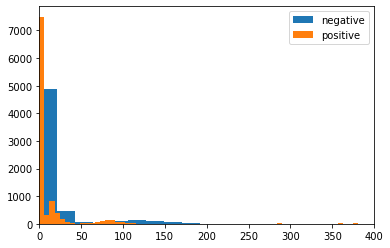

In [5]:
# import seaborn

# 数据直方图
# seaborn.distplot(X.flatten(), bins=200, kde=False, norm_hist=True)
plt.hist(X[y==0].flatten(), bins=200, label='negative')
plt.hist(X[y==1].flatten(), bins=200, label='positive')
plt.legend()
plt.xlim([0, 400])
print('max: %.1f' % X.max())
print('min: %.1f' % X.min())

## 数据集分割
因为有监督方法的引入相当于给模型泄露了答案，所以需要单独分割一个测试集。任何方法都不应该利用到测试集上的信息，包括：**参数搜索，特征归一化，特征选择，特征提取**，等等。

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=728)



In [5]:
# normalize the data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## 高斯核函数

### 基线模型效果，不做参数优化

In [6]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report

clf = SVC(C=1.0, kernel='rbf', gamma=0.1)
clf.fit(X_train, y_train)
train_score = clf.score(X_train, y_train)
test_score = clf.score(X_test, y_test)
print(('train score: {0}; test score: {1}'.format(train_score, test_score)))

train score: 0.989010989010989; test score: 0.9473684210526315


### 搜索最优gamma参数

best param: {'gamma': 0.020433597178569417}
best score: 0.978021978021978
test score: 0.956140350877193


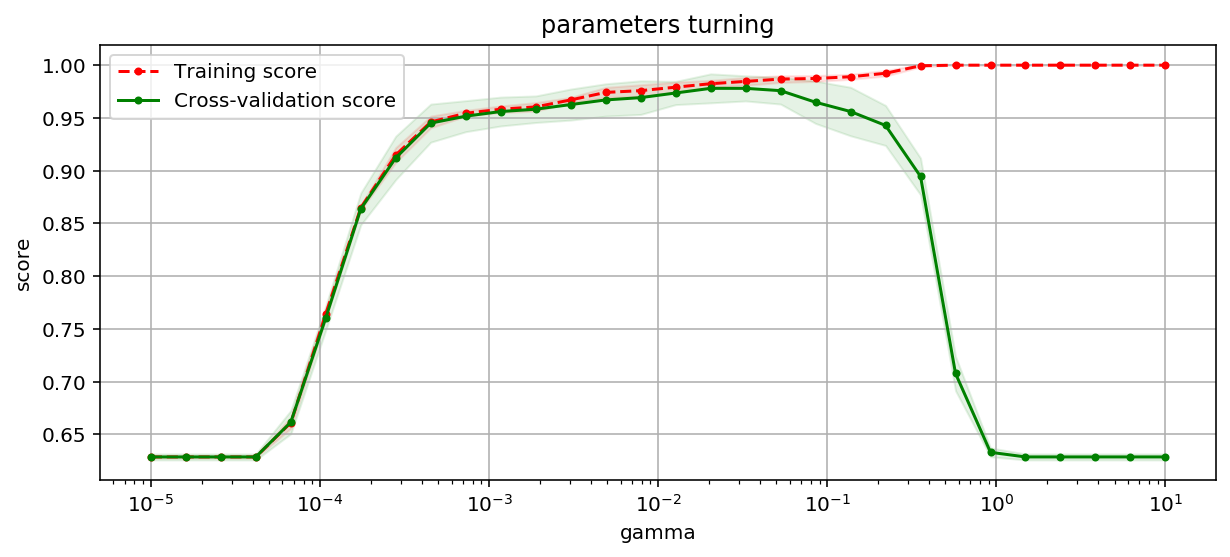

In [7]:
from common.utils import plot_param_curve
from sklearn.model_selection import GridSearchCV  # high level的参数搜索加交叉验证模块

gammas = np.logspace(-5, 1, 30)
param_grid = {'gamma': gammas}
clf = GridSearchCV(SVC(), param_grid, cv=5, return_train_score=True)
# 不要使用到测试集调参
clf.fit(X_train, y_train)
print(("best param: {0}\nbest score: {1}".format(clf.best_params_,
                                                clf.best_score_)))
best_gamma = clf.best_params_['gamma']

plt.figure(figsize=(10, 4), dpi=144)
plot_param_curve(plt, gammas, clf.cv_results_, xlabel='gamma');

# 输出测试集上结果
test_score = clf.score(X_test, y_test)
print(('test score: {0}'.format(test_score)))

### 生成学习曲线（训练效果与样本数量的关系）
Determines cross-validated training and test scores for different training set sizes.

elaspe: 0.169069


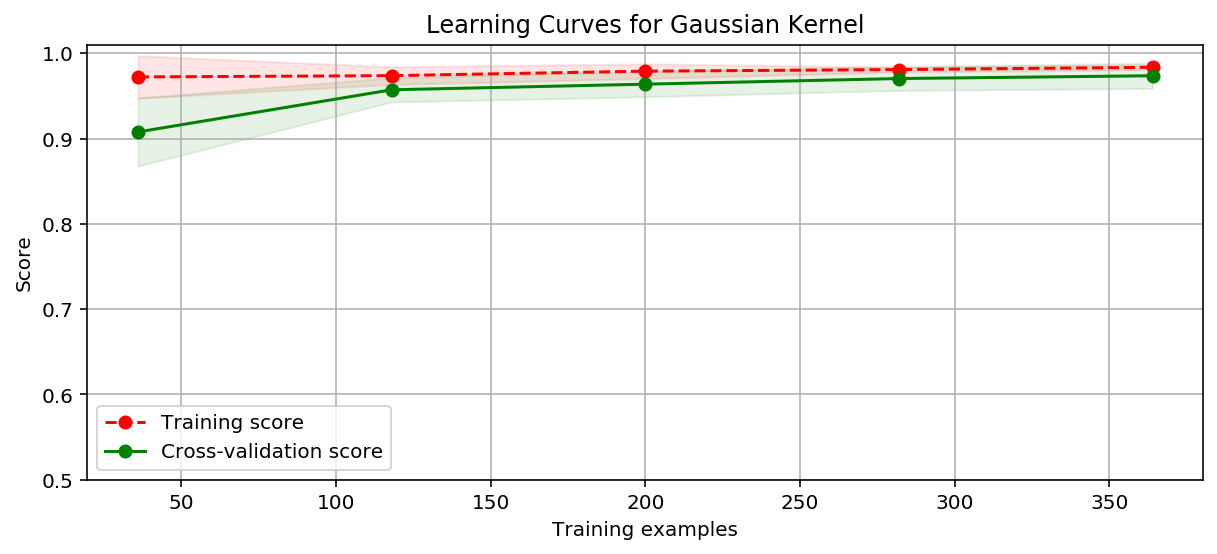

In [8]:
import time
from common.utils import plot_learning_curve
from sklearn.model_selection import ShuffleSplit  # 用于交叉验证，分割过程属于有放回采样（两次分割样本是有重叠的）。

cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
title = 'Learning Curves for Gaussian Kernel'

start = time.clock()
plt.figure(figsize=(10, 4), dpi=144)
plot_learning_curve(plt, SVC(C=1.0, kernel='rbf', gamma=best_gamma),
                    title, X_train, y_train, ylim=(0.5, 1.01), cv=cv)

print(('elaspe: {0:.6f}'.format(time.clock()-start)))

## 多项式核函数

In [9]:
from sklearn.svm import SVC

clf = SVC(C=1.0, kernel='poly', degree=2, coef0=1)
clf.fit(X_train, y_train)
train_score = clf.score(X_train, y_train)
test_score = clf.score(X_test, y_test)
print(('train score: {0}; test score: {1}'.format(train_score, test_score)))

train score: 0.9868131868131869; test score: 0.9385964912280702


elaspe: 2.266595


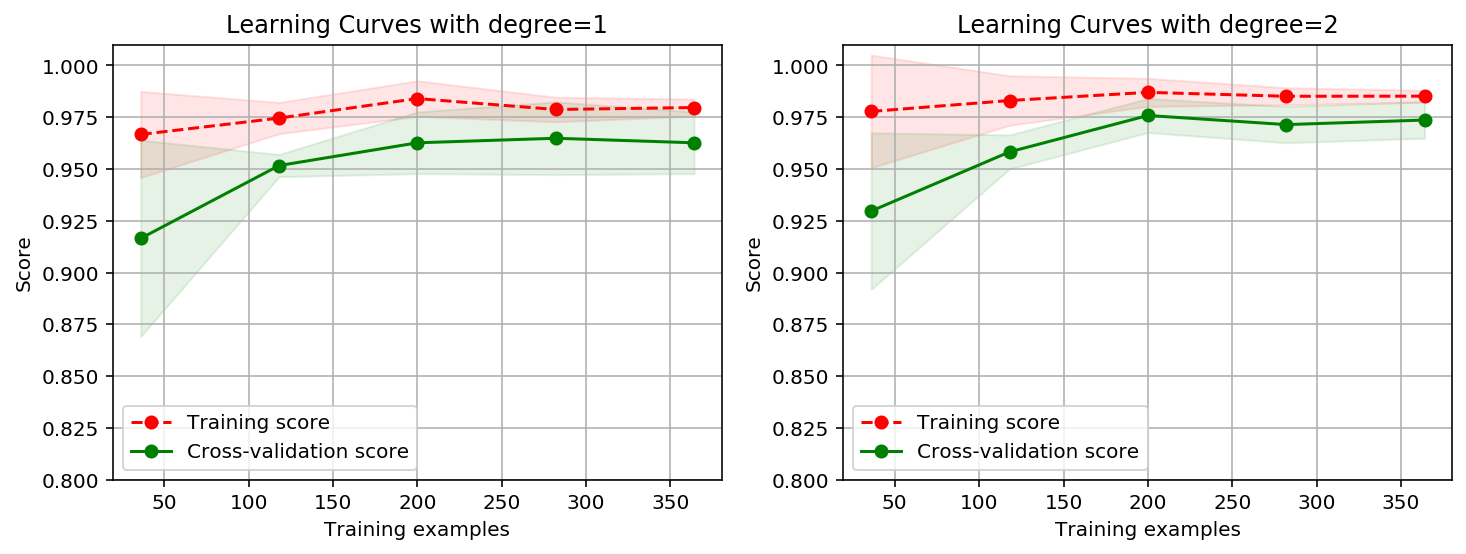

In [10]:
# 维数越高越容易过拟合

import time
from common.utils import plot_learning_curve
from sklearn.model_selection import ShuffleSplit

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
title = 'Learning Curves with degree={0}'
degrees = [1, 2]

start = time.time()
plt.figure(figsize=(12, 4), dpi=144)
for i in range(len(degrees)):
    plt.subplot(1, len(degrees), i + 1)
    plot_learning_curve(plt, SVC(C=1.0, kernel='poly', degree=degrees[i], coef0=1),
                        title.format(degrees[i]), X_train, y_train, ylim=(0.8, 1.01), cv=cv, n_jobs=-1)

print(('elaspe: {0:.6f}'.format(time.time()-start)))

## 多项式 LinearSVC

In [11]:
from sklearn.svm import LinearSVC
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

def create_model(degree=2, **kwarg):
    polynomial_features = PolynomialFeatures(degree=degree,
                                             include_bias=False)
    scaler = MinMaxScaler()  # 因为生成了新的feature，需要重新normalize
    linear_svc = LinearSVC(**kwarg)
    pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("scaler", scaler),
                         ("linear_svc", linear_svc)])
    return pipeline


clf = create_model(penalty='l2', dual=False)
clf.fit(X_train, y_train)
train_score = clf.score(X_train, y_train)
test_score = clf.score(X_test, y_test)
print(('train score: {0}; test score: {1}'.format(train_score, test_score)))

train score: 0.989010989010989; test score: 0.9736842105263158


elaspe: 1.725408


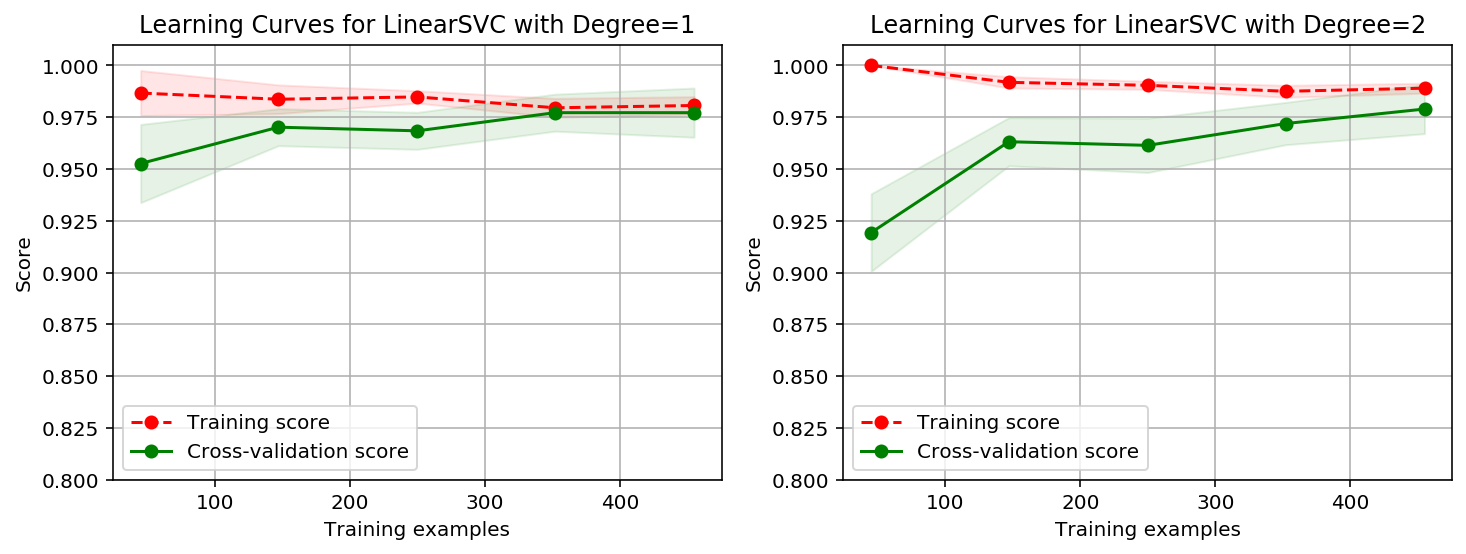

In [12]:
import time
from common.utils import plot_learning_curve
from sklearn.model_selection import ShuffleSplit

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
title = 'Learning Curves for LinearSVC with Degree={0}'
degrees = [1, 2]

start = time.clock()
plt.figure(figsize=(12, 4), dpi=144)
for i in range(len(degrees)):
    plt.subplot(1, len(degrees), i + 1)
    plot_learning_curve(plt, create_model(penalty='l2', dual=False, degree=degrees[i], max_iter=5000),
                        title.format(degrees[i]), X, y, ylim=(0.8, 1.01), cv=cv)

print(('elaspe: {0:.6f}'.format(time.clock()-start)))

## Tune C and gamma

best params on val data:
{'C': 2.154434690031882, 'gamma': 0.021544346900318822}
performance of best params on test data:
0.9649122807017544


Text(0.5, 1.0, 'performance of all parameters on val data')

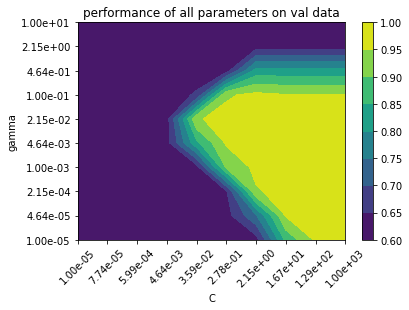

In [13]:
svc = SVC()
parameters={'C':np.logspace(-5, 3, 10),'gamma':np.logspace(-5, 1, 10)}
clf=GridSearchCV(svc, param_grid=parameters, cv=5, n_jobs=-1, scoring='accuracy')
# search on training data
clf.fit(X_train, y_train)

print('best params on val data:')
print((clf.best_params_))
best_model=clf.best_estimator_
print('performance of best params on test data:')
print((best_model.score(X_test,y_test)))

gridx,gridy=np.meshgrid(np.arange(len(parameters['C'])),np.arange(len(parameters['gamma'])))
gridz=clf.cv_results_['mean_test_score']
gridz=np.reshape(gridz,[len(parameters['C']),len(parameters['gamma'])])
gridz=gridz.T

plt.contourf(gridx,gridy,gridz)
plt.colorbar()
plt.xticks(np.arange(len(parameters['C'])), ['%.2e' % c for c in parameters['C']], rotation=45)
plt.yticks(np.arange(len(parameters['gamma'])),['%.2e' % gamma for gamma in parameters['gamma']])
plt.xlabel('C')
plt.ylabel('gamma')
plt.title('performance of all parameters on val data')


## 分类任务的动态评价指标（ROC）

由于分类任务时常会遇到样本不平衡的问题，因此单纯使用准确率作为评价指标会有很大的问题（比如正类：负类=1：1000，那么全判定为负类的准确率有0.999）。使用ROC作为评价指标可以有效避免类别不均衡的影响。

对一个二分类任务，我们的决策可以用下表表示：
![](./confusion_matrix.png)
将阴性错判为阳性称为假阳性错误（Type I error），将阳性错判为阴性称为假阴性错误（Type II error）。

ROC曲线是一个以*tp rate*为Y轴，以*fp rate*为X轴的二维曲线。ROC曲线描述的是收益(true positives)与损失(false positives)的折中。

ROC曲线下的面积（AUC）通常被用来作为评价一个分类器的性能。分类器的性能越好，AUC应该越大。图中的B分类器要好于A分类器。
![](./AUC.png)

*Fawcett, T. (2006). An introduction to ROC analysis. Pattern recognition letters, 27(8), 861-874.*

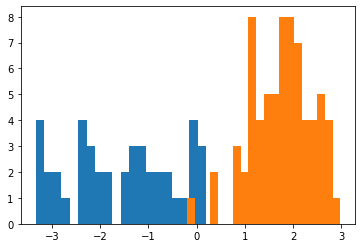

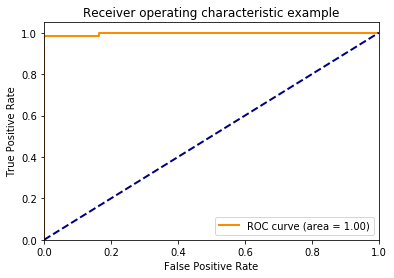

In [14]:
# 画出最终分类器的ROC曲线
from sklearn.metrics import roc_curve, auc

y_score = clf.decision_function(X_test)
plt.figure()
plt.hist(y_score[y_test == 0], bins=20)
plt.hist(y_score[y_test == 1], bins=20)
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()